## 02. XGBoost for Aerial LiDAR Data Classification with extended training dataset

<br>


Due to the fact that our XGBoost model got quite poor accuracy (__54.90%__) on test dataset (with great score on training area: __94.99%__) in this notebook we will try to otpimize the previous work on __LiDAR__ data classification. 

The first and the biggest change will be merging __6 training / validation areas__ in order to avoid overfitting our model. Next we will measure our results on the test area from the previous notebook.


### Table of Contents

    1.Train / test dataset

        1.1 Data analysis
        1.2 Data sampling
        1.3 XGBoost - default
        1.4 XGBoost - tuned
    
    2.Test dataset
    
        2.1 Data analysis
        2.2 XGBoost - default
        2.3 XGBoost - tuned




## 1.Train / test dataset
### 1.1 Data analysis

The dataset composes of seven areas - six for __Training / Validation__ and one __Test Area__ for final independent accuracy testing. They all cover a selected area of Peplin municipality.


<img src="img/Zakres_1_6_2d.JPG" width="80%">

In the next steps we will read and analyze the __Train / Validation Areas__.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
tv_area = pd.concat([pd.read_csv(r'data\02.Train_Validation_Area_1.csv', header=0, delimiter=' '),
                     pd.read_csv(r'data\02.Train_Validation_Area_2.csv', header=0, delimiter=' '),
                     pd.read_csv(r'data\02.Train_Validation_Area_3.csv', header=0, delimiter=' '),
                     pd.read_csv(r'data\02.Train_Validation_Area_4.csv', header=0, delimiter=' '),
                     pd.read_csv(r'data\02.Train_Validation_Area_5.csv', header=0, delimiter=' '),
                     pd.read_csv(r'data\02.Train_Validation_Area_6.csv', header=0, delimiter=' ')],
                     ignore_index=True)

In [3]:
tv_area.sample(20)

,//X,Y,Z,R,G,B,PointSourceId,ScanAngleRank,ScanDirectionFlag,NumberOfReturns,ReturnNumber,Intensity,Classification
125266,484243.50000,676340.0625,50.680000,125,138,119,102.0,-11.0,1.0,1.0,1.0,65.0,2.0
252797,484406.96875,676595.2500,50.630001,49,76,59,102.0,0.0,1.0,1.0,1.0,64.0,2.0
413065,484586.50000,676288.2500,57.459999,53,59,53,102.0,14.0,1.0,1.0,1.0,83.0,0.0
176141,484404.12500,676325.5000,55.939999,111,112,106,102.0,1.0,1.0,3.0,3.0,30.0,2.0
213615,484384.87500,676360.8750,55.970001,124,137,115,102.0,-1.0,1.0,1.0,1.0,86.0,2.0
483941,484437.03125,676113.1250,53.169998,120,125,105,102.0,3.0,1.0,2.0,2.0,56.0,2.0
203293,484456.46875,676330.1250,54.900002,98,111,90,102.0,4.0,1.0,1.0,1.0,95.0,2.0
182275,484373.65625,676343.6250,55.790001,70,91,75,102.0,-2.0,1.0,1.0,1.0,73.0,2.0
292985,484270.12500,676986.1250,52.290001,73,74,69,102.0,-10.0,1.0,1.0,1.0,87.0,3.0
136093,484321.68750,676353.3125,55.119999,118,115,98,102.0,-6.0,1.0,1.0,1.0,89.0,2.0


Just the reminder of feature explanation:

__LiDAR__ per-point data attriubtes definition:
 
__X__,__Y__ - The planimetric ground location of the point,

__Z__ - The elevation of the point,

__R__,__G__,__B__ - Additive color model values,

__PointSourceId__ - A unique identifier to reference this point back to a collection source,

__ScanAngleRank__ - Angle at which the laser point was output from the laser system including the roll of the aircraft,

__ScanDirectionFlag__ - Direction the laser scanning mirror was traveling at the time of the output laser pulse,

__NumberOfReturns__ - Number of returns detected for a given transmitted pulse,

__Intensity__ - The laser pulse return intensity at the sensor,

__Classification__ - Surface attribute assigned to this point such as ground, vegetation.

In [4]:
tv_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489029 entries, 0 to 489028
Data columns (total 13 columns):
//X                  489029 non-null float64
Y                    489029 non-null float64
Z                    489029 non-null float64
R                    489029 non-null int64
G                    489029 non-null int64
B                    489029 non-null int64
PointSourceId        489029 non-null float64
ScanAngleRank        489029 non-null float64
ScanDirectionFlag    489029 non-null float64
NumberOfReturns      489029 non-null float64
ReturnNumber         489029 non-null float64
Intensity            489029 non-null float64
Classification       489029 non-null float64
dtypes: float64(10), int64(3)
memory usage: 48.5 MB


We can see that there are only numerical features and that there are no null values within all data, so we can proceed with further analysis.

In [5]:
tv_area.nunique()

//X                  16694
Y                     9620
Z                     2905
R                      238
G                      227
B                      231
PointSourceId            2
ScanAngleRank           34
ScanDirectionFlag        1
NumberOfReturns          5
ReturnNumber             5
Intensity              225
Classification           8
dtype: int64

In [6]:
tv_area.describe()

,//X,Y,Z,R,G,B,PointSourceId,ScanAngleRank,ScanDirectionFlag,NumberOfReturns,ReturnNumber,Intensity,Classification
count,489029.000000,489029.000000,489029.000000,489029.000000,489029.000000,489029.000000,489029.000000,489029.000000,489029.0,489029.000000,489029.000000,489029.000000,489029.000000
mean,484429.029700,676410.149605,54.452942,107.389008,112.246261,100.769155,102.078290,0.483853,1.0,1.111748,1.055952,75.933998,2.517849
std,161.461443,249.742755,3.610070,45.041527,39.157022,37.233928,0.268627,8.342436,0.0,0.368680,0.255040,29.930130,1.457988
min,484189.906250,676038.062500,48.029999,17.000000,27.000000,20.000000,102.000000,-15.000000,1.0,1.000000,1.000000,8.000000,0.000000
25%,484313.375000,676279.312500,51.869999,76.000000,87.000000,77.000000,102.000000,-6.000000,1.0,1.000000,1.000000,60.000000,2.000000
50%,484412.000000,676324.437500,54.430000,107.000000,114.000000,98.000000,102.000000,1.000000,1.0,1.000000,1.000000,76.000000,2.000000
75%,484475.375000,676540.937500,55.830002,132.000000,131.000000,114.000000,102.000000,6.000000,1.0,1.000000,1.000000,93.000000,2.000000
max,484913.156250,677053.500000,78.730003,255.000000,255.000000,255.000000,103.000000,25.000000,1.0,5.000000,5.000000,1011.000000,12.000000


Next we will invest feature importance for further predictions.

Because __'PointSourceId'__ and __'ScanDirectionFlag'__ columns consists with accordingly 2 and 1 value we can assuredly delete them.

Another aspect are __'X'__ and __'Y'__ coordinates that are values differrent for each point and have no correlation with different spatial areas and should also be deleted.

In [7]:
tv_area = tv_area.drop(['PointSourceId', 'ScanDirectionFlag', '//X', 'Y'], axis = 1)

As we know from previous notebook there is a vast majority of values classify as Ground (2), so we are dealing with a disproportionate ratio of observations in each class, that will obviously lower our measures performance.


### 1.2 Data sampling

We will use __down-sampling__ for majority class - Ground (2), and __up-sampling__ for other classes, setting the number of samples to match __5000 features__ for all categories.

We will use the scheme of Up-sample Minority Class and Down-sample Majority Class from  https://elitedatascience.com/imbalanced-classes.

First we have to split our data to __train / test__ datasets in order not to interfere with further model accuracy measurement on test data.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [9]:
X = tv_area.iloc[:,0:8]
X.head(5)

,Z,R,G,B,ScanAngleRank,NumberOfReturns,ReturnNumber,Intensity
0,51.689999,130,124,111,-10.0,1.0,1.0,102.0
1,51.650002,135,132,117,-10.0,1.0,1.0,118.0
2,51.669998,128,121,107,-10.0,1.0,1.0,92.0
3,51.700001,121,114,101,-10.0,1.0,1.0,104.0
4,51.709999,115,107,94,-10.0,1.0,1.0,91.0


In [10]:
y = tv_area.iloc[:,8]
y.sample(5)

163033    2.0
309058    2.0
349232    2.0
12924     2.0
475378    2.0
Name: Classification, dtype: float64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

Next we concatenate our X_train and y_train data in order to handle our imbalanced classes.

In [12]:
tv_area_train = pd.concat([X_train, y_train], axis=1, join='inner')
print(tv_area_train.head(5))

                Z    R    G    B  ScanAngleRank  NumberOfReturns  \
294953  53.880001   88   98   91           -9.0              1.0   
147325  50.049999  125  121  109          -14.0              1.0   
362993  56.630001   29   41   48           12.0              1.0   
299592  52.009998   46   55   57          -13.0              1.0   
164285  54.419998  134  130  103           -6.0              1.0   

        ReturnNumber  Intensity  Classification  
294953           1.0       44.0             4.0  
147325           1.0       71.0             2.0  
362993           1.0       56.0             2.0  
299592           1.0       81.0             2.0  
164285           1.0       62.0             2.0  


In [13]:
print(tv_area_train.Classification.value_counts()) # train data imbalanced classes

2.0     258337
6.0      27104
5.0      16275
0.0      10378
3.0       8514
4.0       5695
12.0      1309
7.0         37
Name: Classification, dtype: int64


In [14]:
random_state = 123
n_samples = 25000

In [15]:
tv_area_majority_2 = tv_area_train[tv_area_train.Classification==2] # extraction of Ground features

In [16]:
tv_area_majority_2_upsampled = resample(tv_area_majority_2, 
                                 replace=False,              # sample without replacement
                                 n_samples=n_samples,        # n_samples chosen for down-sampling
                                 random_state=random_state)  # reproducible results

In [17]:
tv_area_minority_0 = tv_area_train[tv_area_train.Classification==0] # extraction of Never classified features
tv_area_minority_3 = tv_area_train[tv_area_train.Classification==3] # extraction of Low Vegetation features
tv_area_minority_4 = tv_area_train[tv_area_train.Classification==4] # extraction of Medium Vegetation features
tv_area_minority_5 = tv_area_train[tv_area_train.Classification==5] # extraction of High Vegetation features
tv_area_minority_6 = tv_area_train[tv_area_train.Classification==6] # extraction of Building features
tv_area_minority_7 = tv_area_train[tv_area_train.Classification==7] # extraction of Noise features
tv_area_minority_12 = tv_area_train[tv_area_train.Classification==12] # extraction of Overlap (Reserved) features

In [18]:
tv_area_minority_0_upsampled = resample(tv_area_minority_0, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

tv_area_minority_3_upsampled = resample(tv_area_minority_3, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

tv_area_minority_4_upsampled = resample(tv_area_minority_4, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

tv_area_minority_5_upsampled = resample(tv_area_minority_5, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

tv_area_minority_6_upsampled = resample(tv_area_minority_6, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

tv_area_minority_7_upsampled = resample(tv_area_minority_7, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

tv_area_minority_12_upsampled = resample(tv_area_minority_12, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

In [19]:
tv_area_train_sampled = pd.concat([tv_area_minority_0_upsampled, tv_area_majority_2_upsampled, 
                                     tv_area_minority_3_upsampled, tv_area_minority_4_upsampled, 
                                     tv_area_minority_5_upsampled, tv_area_minority_6_upsampled, 
                                     tv_area_minority_7_upsampled, tv_area_minority_12_upsampled ])

In [20]:
tv_area_train_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 44020 to 392973
Data columns (total 9 columns):
Z                  200000 non-null float64
R                  200000 non-null int64
G                  200000 non-null int64
B                  200000 non-null int64
ScanAngleRank      200000 non-null float64
NumberOfReturns    200000 non-null float64
ReturnNumber       200000 non-null float64
Intensity          200000 non-null float64
Classification     200000 non-null float64
dtypes: float64(6), int64(3)
memory usage: 15.3 MB


In [21]:
tv_area_train_sampled.Classification.value_counts() #we now have 200 000 points in our training dataset

7.0     25000
12.0    25000
5.0     25000
6.0     25000
4.0     25000
3.0     25000
2.0     25000
0.0     25000
Name: Classification, dtype: int64

In [22]:
X_train = tv_area_train_sampled.iloc[:, :8]
y_train = tv_area_train_sampled.iloc[:, 8]

In [23]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

In [24]:
X_train = mm.fit_transform(X_train)
X_test = mm.fit_transform(X_test)

### 1.3 XGBoost - default

In next step we will use an advanced implementation of gradient boosting algorithm - __XGBoost__.

First with default settings (we will work only with scaled data from now on).

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [26]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_train)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(model_xgb)

Accuracy: 76.36%
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [27]:
y_pred = model_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 62.06%


We see a lower score than in previous notebook, which may be the fact of vast majority of different training points.

### 1.4 XGBoost - tuned

We will use the hyperparameters from previous notebook and see if they are still better than dafault XGBoost algorithm.

In [28]:
best_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                           colsample_bytree=0.6, gamma=0.0, learning_rate=0.01,
                           max_delta_step=0, max_depth=50, min_child_weight=1, missing=None,
                           n_estimators=1000, n_jobs=1, nthread=None,
                           objective='multi:softprob', random_state=0, reg_alpha=1e-07,
                           reg_lambda=0.001, scale_pos_weight=1, seed=None, silent=True,
                           subsample=0.9)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_train)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [29]:
y_pred = best_model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.55%


Accuracy is better than in previous notebook (71.07%) so lets see if we still fall into an overfitting dilema.

## 2.Test dataset

### 2.1 Data analysis

Test area consists of 46 973 LiDAR points located over 9 896 square meters.

<img src='img/Zakres2_2d.jpg' width="80%">

Test area is the replica of previous notebook so we only do a pie chart of 'Classification' columns.

In [30]:
t_area = pd.read_csv('data/02.Test_Area.csv', header=0, delimiter=' ')
t_area = t_area.drop(['PointSourceId', 'ScanDirectionFlag', 'X', 'Y'], axis = 1)

In [31]:
X2 = t_area.iloc[:,0:8]
y2 = t_area.iloc[:,8]

In [32]:
X2.head(5)

,Z,R,G,B,ScanAngleRank,NumberOfReturns,ReturnNumber,Intensity
0,50.580002,79,102,85,6.0,1.0,1.0,62.0
1,50.580002,75,98,80,6.0,1.0,1.0,80.0
2,50.580002,68,91,74,6.0,1.0,1.0,84.0
3,50.650002,82,105,87,6.0,1.0,1.0,82.0
4,50.590000,96,118,100,6.0,1.0,1.0,82.0


In [33]:
y2.head(5)

0    2.0
1    2.0
2    2.0
3    2.0
4    2.0
Name: Classification, dtype: float64

In [34]:
np.unique(t_area.Classification, return_counts=True)

(array([0., 2., 3., 4., 5., 6., 7.]),
 array([  745, 31236,   973,   783,  4241,  5454,     8], dtype=int64))

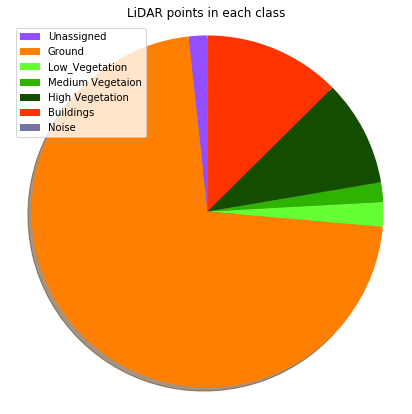

In [37]:
import matplotlib.pyplot as plt

labels = ['Unassigned', 'Ground', 'Low_Vegetation', 'Medium Vegetaion', 'High Vegetation', 'Buildings', 'Noise']

colors = ['#944dff', '#ff8000', '#66ff33', '#2db300', '#134d00', '#ff3300', '#7575a3']

plt.figure(figsize=(7,7))

sizes = np.unique(t_area.Classification, return_counts=True)[1]

patches, texts = plt.pie(sizes, shadow=True, startangle=90, colors=colors)

plt.legend(patches, labels, loc="best")

plt.title('LiDAR points in each class')

plt.axis('equal')

plt.show()

In [38]:
X2 = mm.fit_transform(X2) #we scale our data as in the first train/test area

### 2.2 XGBoost - default

In [39]:
y2_pred = model_xgb.predict(X2)
predictions2 = [round(value) for value in y2_pred]
accuracy = accuracy_score(y2, predictions2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 49.61%


Slightly better, but still not good for future work with LiDAR datasets.

### 2.3 XGBoost - tuned

In [40]:
y2_pred = best_model.predict(X2)
predictions2 = [round(value) for value in y2_pred]
accuracy = accuracy_score(y2, predictions2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 37.36%


And a shcoker here ! We can see that we have got even worse accuracy scores than on smaller training datasets!

The problem of __overfitting__ still exists and we should find other way to implement our data or increase the number of instances.